<a href="https://colab.research.google.com/github/lalit-jamdagnee/Learning_ML/blob/main/Ensemble_Learning_and_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert's answer. This is called the **wisdom of the crowd**.

Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an **ensemble**, thus this technique is called **Ensemble Learning**, and an Ensemble Learning algorithm is called an **Ensemble method.**

As an example of an Ensemble method, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you obetain the predictions of all the individual trees, then predict the class that gets the most votes. Such an ensemble of Decision trees is called a **Random Forest**, and despite its simplicity, this is one of the most powerful Machine laernign algorithms available today.

In this chaper we will discuss the most popular Enselmbe methods, including *bagging, boosting* and *stacking*. We will also explore Rnadom Forests.


# Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. Yo may have a Logistic Regression Classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more.

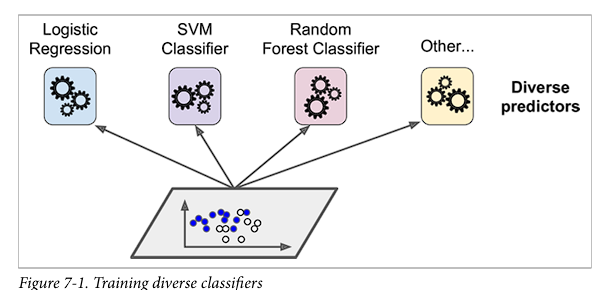

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most ovtes. This majority-vote classifier is called a **hard voting classifier**.

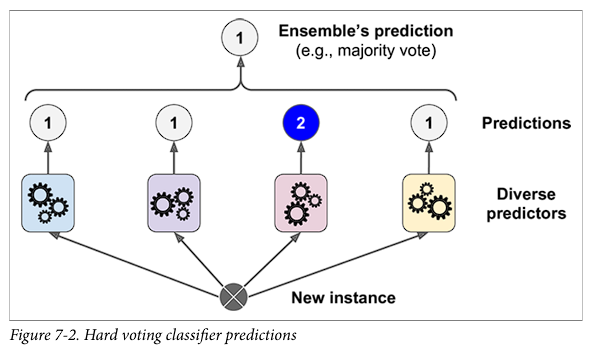

Somewhat surprisingly, this voting classifier often achieves a hihger accuracy than the best classifier in the ensemble. In fact, even if each classifier is a *weak learner* ( meaning it does a slightly better than random guessing), the ensembe can still be a *strong learner* (acheiving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.

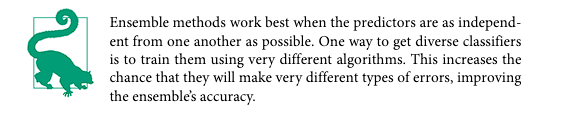

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifers:

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples= 10000, noise= 0.4, random_state=42)

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard'
)

In [4]:
# lets look at each classifier's accuracy on the test set

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8295
RandomForestClassifier 0.8485
SVC 0.8675
VotingClassifier 0.8605


If all classifiers are able to estimate class probabilites (i.e., they all have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace *voting="hard"* with *voting="soft"* and ensure that all classifiers can estimate class probabilities. This is not the case for the SVC class by default, so you need to set its *probability* hyperparameter to *True* (this will make the *SVC* class use cross-validation to estimate class probabilities, slowign down training and it will add a *predict_proba()* mthod). Let's do it

In [5]:
svm_clf = SVC(probability = True)
voting_classifier = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft'
)

In [6]:
for clf in [log_clf, svm_clf, rnd_clf, voting_classifier]:
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8295
SVC 0.8675
RandomForestClassifier 0.8495
VotingClassifier 0.866


We can clearly see that *voting="soft"* gives a better prediction to us as compared to the *voting="hard"* hyperaparameter, we just have to make sure that all the classifiers have the estimate probability class.

# Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms as just discussed above. Another approach is to use the same training algorithm for every predictor and train them on different random subsets of the training set.

When sampling is performed with replacement, this method is called **bagging** (short for *bootstrap aggregating*). When sampling is performed without replacement, it is called **pasting**.

In other words, both bagging and pasting allow training instances to be sampeld serveral times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. This sampling and training process is represented below:

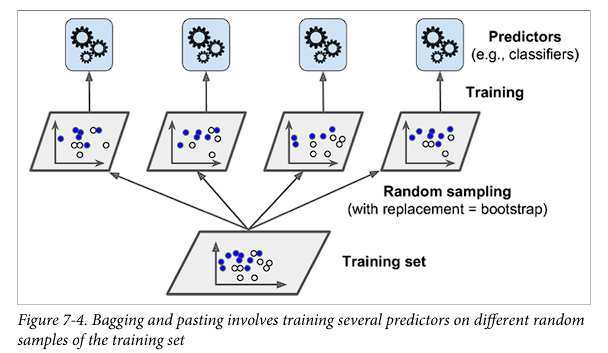

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the *statistical mode* (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, they net result is that the ensemble has a similar bias but a lower variance than a sngle predictor trained on the original training set.

From the figure you can see that the predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, prediction can be made in parallel. This is one of the reasons bagging  and pasting are such popoular methods: they scale very well.

## Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the **Baggingclassifier** class( or **BaggingRegressor** for regression). The following code trains an ensemble of 500 Decision Tree classifiers, each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, for pasting set *bootstrap=False*). The n_jobs parameter tells Scikit-learn the number of CPU cores to use for training and predictions (-1 tells the Scikit-Learn to use all available cores):

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train )
y_pred = bag_clf.predict(X_test)

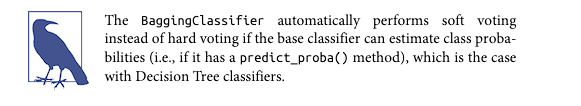

In [8]:
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.867


Figure below compares the decision boundary of a sinlge Decision Tree with the decision boundary of a baggin ensemble of 500 trees, both trained on the moon dataset. As we can see, the ensemble's predictions will likely to generlaize much better than the single Decision Tree's predictions: the ensemble has a comparable bias but a smaller variance

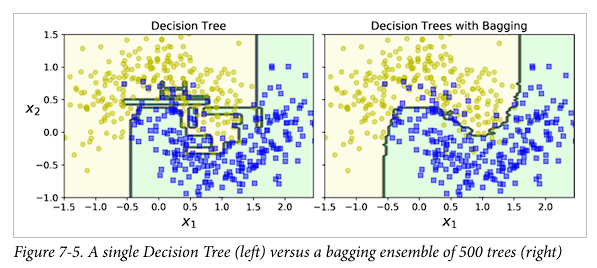

Overall, bagging often results in better models, which explains why it is generally preferred.

## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a **BaggingClassifier** samples m training instances with replacement (**bootstrap=True**), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called **out-of-bag** (oob) instances.

Since a predictor never sees the oob instances during the training, it can be evaluated on these instances, without the need for a seperate validation set. you can evaluate the ensemble itself by averageing out the oob evaluations of eac predictor.

In Scikit-Learn, you can set **oob_score = True** when creating a **BaggingClassifier** to request an automatic oob evaluation after training. The following code demonstratest this. The resulting evaluation score is available throught **oob_score_** variable

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators= 500,
    bootstrap = True, oob_score = True
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  oob_score=True)

In [10]:
bag_clf.oob_score_

0.83725

According to this oob evaluation, this **BaggingClassifier** is likely to achieve about 83.7% accuracy on the test set. Let's verify this:

In [11]:
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.843


We got 84% accuracy on the test set, which is very close to 83.7% oob_score_

The oob decision function for each training instance is also available through the **oob_decision__function_** variable. In this case ( the base estimator has a predict_proba() method), the decision function returns the class probabilites for each training instances.

In [12]:
bag_clf.oob_decision_function_

array([[0.00531915, 0.99468085],
       [0.        , 1.        ],
       [1.        , 0.        ],
       ...,
       [0.99459459, 0.00540541],
       [0.88461538, 0.11538462],
       [0.81865285, 0.18134715]])

For the first training instance the oob evaluation estimates the 72.9% probabiliy of the positive class

## Random Patches and Random Subspaces

The **BaggingClassifier** class supports sampling the features as well. Sampling is controlled by two hyperparameters: **max_features** and **bootstrap_features**. They work the same way as **max_samples** and **bootstrap**, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of input features.

This technique is particularly useful whenyou are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called **Random Patches method**. Keeping all training instances (by setting **bootstrap=False** and **max_samples=1.0**) but sampling features (by setting **bootstrap_features** to **True** and/or **max_features** to a value smaller than **1.0**) is called **Random Subspaces method**.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests

As we discussed, a **Random Forest** is an ensemble of Decision Tree, generally trained via the bagging method, typically with **max_samples** set to the size of the training set. Instead of building **BaggingClassifier** and passing it a **DecisionTreeClassifier**, we can instead use the **RandomForestClassifier** class, which is more convenient and optimized for Decision Trees ( similary there is **RandomForestRegressor** for regression tasks). The following code uses all available CPU cores to train a Random Forest classifier with 500 trees

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [14]:
y_pred = rnd_clf.predict(X_test)
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.8655


With a few exceptions, a **RandomForestClassifier** has all the hyperparameters of **DecisionTreeClassifier**, plus all the hyperparameters of a **BaggingClassifier** to control the ensemble itself.



The following **BaggingClassifier** is roughly equivalent to the previous **RandomForestClassifier**

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators = 500, max_samples = 1.0,bootstrap=True, n_jobs= -1
)

### Extra-Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting. It is possible to make trees even more random by also uring random thresholds for each feature rather than searching for the best possible thresholds.

A forest of such extremely random trees is called an **Extremely Randomized trees** ( or **Extra-Trees** for short). Once again, this technique trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests, because finding thebest possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create an Extra-Trees classifier using Scikit-Learn's **ExtraTreesClassifier** class. Its API is identical to the **RandomForestClassifier** class.

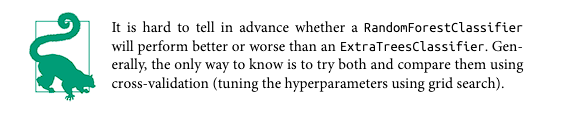

### Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learns measures a feature's importance by looking at how much the tree nodes that use that feature reduce impurity on average.

Scikit-Learn computes this core automatically for each feature after training. The sum of all the importances is equal to 1. Wew can access the result using **feature_importance_** variable.

For example, the following code trains a **RandomForestClassifier** on the iris dataset and outputs each feature's importance.

In [16]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris["data"], iris["target"])


RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [17]:
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09162107205915972
sepal width (cm) 0.022615060731934845
petal length (cm) 0.4276981151818027
petal width (cm) 0.4580657520271027


It seems that the most important features are the petal length (43%) and petal width (44%), while sepal length and width are rather unimportant in comparison.

# Boosting

**Boosting** (originally called **hypothesis boosting**) refers to any Ensemble method that can combine sesveral weak learners into a string learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are **AdaBoost** (short for *Adaptive Boosting*) and **Gradient Boosting**. Let's stat with *AdaBoost*.

## AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training isntances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, when training an Adaboost classifier, the algorithm first trains a base classifier (such as as Decision tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

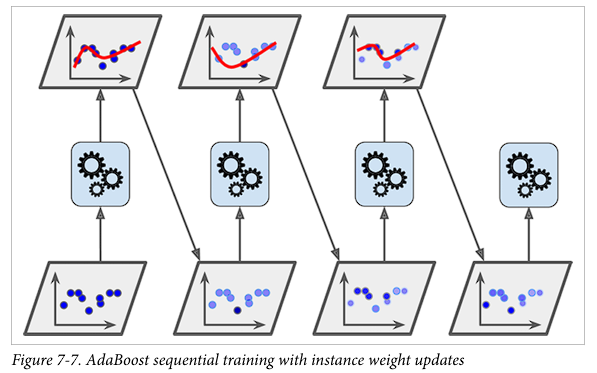

The plot on the right represents the same sequence of predictors as in the above figure, except that the learning rate is halved (i.e., the misclassified instnaces weights are boosted half as much as at every iteration). As you can see, this sequential learning techinque has some similarities with Gradient Descent, except that intead of tweaking a single predictor's parameters to minimize the cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

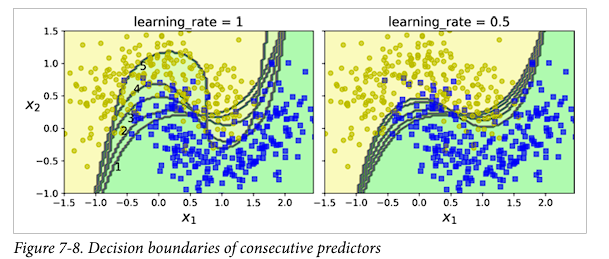

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

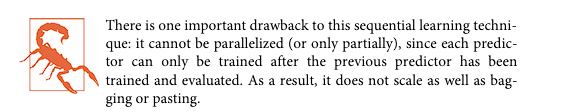

Scikit-Learn uses a multiclass version of AdaBoost called **SAMME** ( which stands for *Stagewise Additive Modeling using a Multiclass Exponential loss function*). WHere there are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate class probabilites (i.e. if they have *predict_proba()* method). Scikit-Learncan use a variant of SAMME called SAMMER (the R stands for "real"), which relies on class probabilities rather than predictions and generally performs better.

THe following code trains an AdaBoost classifier based on 200 *Decision Stumps* using Scikit-Learns **AdaBoostClassifier** class ( and **AdaBoostRegressor** for regression). A Decision stump is a Decision Tree with *max_depth=1* - in other words, a tree composed of a single decision node plust two leaf nodes. This is default base estimator for the **AdaBoostClassifier**.

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm="SAMME.R", learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [19]:
y_pred = ada_clf.predict(X_test)

print(ada_clf.__class__.__name__, accuracy_score(y_test, y_pred))

AdaBoostClassifier 0.863


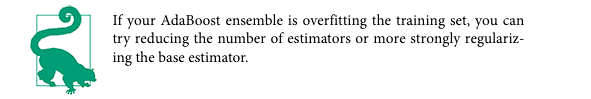

## Gradient Boosting

Another very popular boosting algorithm is **Gradient Boosting**. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weight at every iteration like AdaBoost does, this method tries to fit the new predictor to the *residual errors* made by the previous predictor.

Let's go through a simple regression example, using Decision Trees as the base predictors. This is called **Gradient Tree Boosting** or **Gradient Boosted Regression Trees** (GBRT). First, let's fit a **DecisionTreeRegressor** to the training set

In [20]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_new, y_new = make_moons(n_samples=500, noise=0.30, random_state=42)

In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

Next, we'll train a second **DecisionTreeRegressor** on the residual errors made by the first predictor

In [22]:
tree_reg2 = DecisionTreeRegressor(max_depth=2)
y2 = y - tree_reg1.predict(X)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [23]:
# Then we train a third regressor on the residual errors made by the
# second predictor
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

Now we have an ensembe containing three trees. It can make prediction on a new instance simply by adding up the predictions of all the trees:

In [24]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [25]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_new, y_pred)
print("MSE : ", mse)

MSE :  0.07073392299326108


The Figure below represents the predictions of these three trees in the left column, and the ensemble's predictions in the right column. Iin the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree's predictions. IN the second row a nwe tree is trained on the residual error of the first tree. One the right you can see that the ensemble's predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble's predictions gradually get better as trees are added to the ensemble.

A simpler way to train GBRT ensembles is to use Scikit-Learn's **GradientBoostingRegressor** class. Much like the **RandomForestRegressor** class, it has hyperparameters to control the growth of Decision Trees (e.g., **max_depth, min_samples_leaf**), as well as hyperparameters to control the ensemble training, such as the number of trees (**n_estimators**). The following code creates the same ensemble as the previous one:

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth = 2, n_estimators = 3, learning_rate=1.0
)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [27]:
y_pred = gbrt.predict(X_new)
mse = mean_squared_error(y_new, y_pred)
print("MSE : ", mse)

MSE :  0.07073392299326109


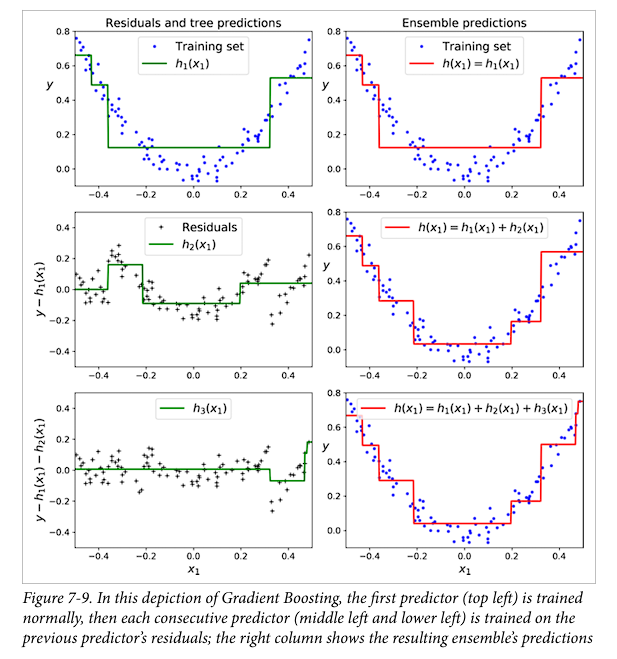

The *learning_rate* hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called *shrinkage*.

Figure below shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enought trees to fit the training set while the one on the right has too many trees and overfits the training set.

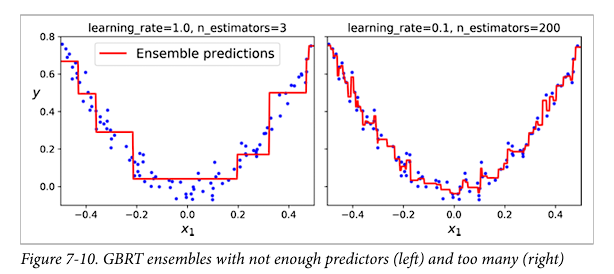

In order to find the optimal number of trees, you can use early stopping. A simple way to impolement this is to use the **staged_predict()** method: it returns an iterator over the predictions made by the ensemble at each stage of training.

The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trians another GBRT ensemble using the optimal number of trees:

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators= bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=67)

The validation errors are represented on the left plot of the figure below, and the best model's predictions are represented on the right.

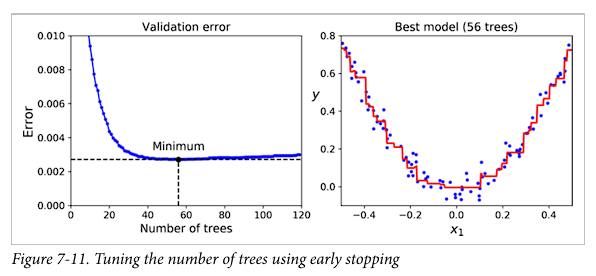

It is also possible to implement early stopping by actually stopping training early . We can do so by setting **warm_start=True**, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row:

In [29]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break

In [30]:
print(min_val_error)

0.07538142725065883


The **GradientBoostingRegressor** class also supports a **subsample** hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if subsample = 0.25, then each tree is trained on 25% of the training instances selected randomly. It also speeds up training considerably. This is called *Stochastic Gradient Boosting*.

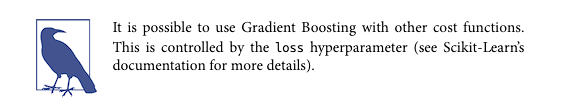

It is worth noting an optimized implementation of Gradient Boosting is available in the popular Python library **XGBoost**, which stands for Extreme Gradient Boosting. XGBoost's API is quite similar to Scikit-Learn's:

In [32]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
print("MSE :", mean_squared_error(y_val, y_pred))

MSE : 0.11280239009038882


In [37]:
!pip install xgboost --version

In [38]:
# XGBoost also offers several nice features, such as automatically taking
# care of early stopping:

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
print("MSE :", mean_squared_error(y_val, y_pred))

# Stacking

The last Ensemle method that we will discuss in this chapter is called stacking (short for *stack generalization*). It is based on a simple idea: instead of using trivial functions ( such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don't we train a model to perform this aggregation.

Figure below shows a ensemlbe performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7 and 2.9) and then the final predictor (called a *blender*, or a *meta learner*) takes these predictions as inputs and makes the final predictions (3.0)

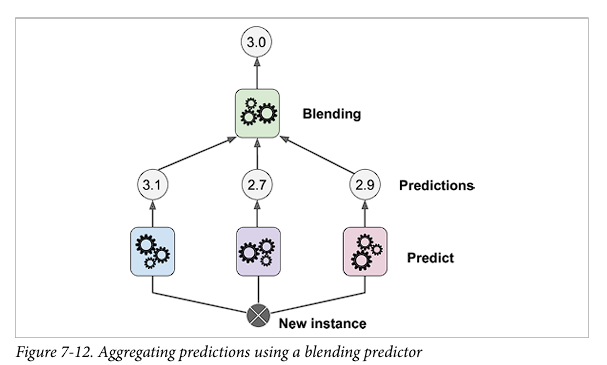

To train the blender, a common approach is to use a hold-out set. Let's see how it works. First, the training set is split into two subsets. the first subset is used to train the predictors in the first layer.

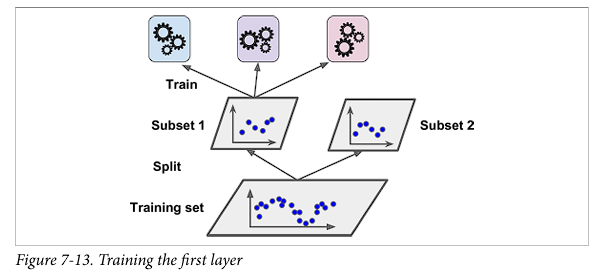

Next, the first layer's predictors are used to make predictions on the second set. This ensures that the predictions are "clean", since the predictors never saw these instances during training. For each instance in the hold-outset, there are three predicted values. We can create a new training set using these predicted values as input features (which makes this new training set 3D), and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value, given the first layer's predictions

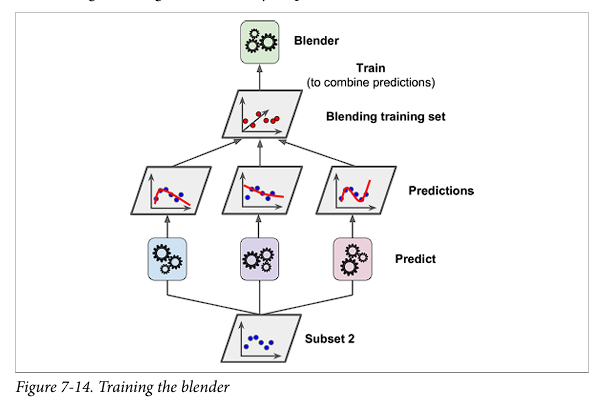

It is actually possible to train several different blenders this way (e.g. one using linear regression, another using random forest regression), to get a hole layer of blenders. The trick is to split the training set into three subsets.: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using the predictions made by the predictors of the second layer). Once this is done, we can make predictions for a new instance by going through each layer sequentially.

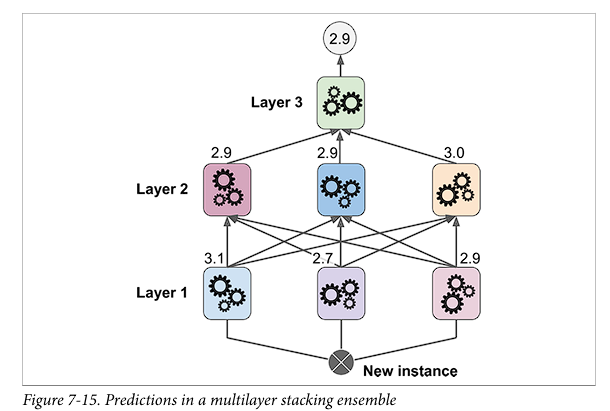

Unfortunately, Scikit-Learn does not support stacking directly. Alternatively, you  use an open source implementation such as **DESlib**.